### NLTK Stop Words Exploration
#### Author: Alex Oesterling
##### Goals: develop stop-word embeddings of citation contexts for use in detecting grammatical features (do Background citations use more of certain stop words than others?)
##### Hypothesis: certain citation types use more stopwords than others. By embeding stop word features, we can use a classifier to divide citation contexts based on stop words only.

Experiments: Corpus size
* All citation contexts
* Sample scientific corpus from nltk (Brown, couldn't find a true scientific corpus when I checked)

In [1]:
import nltk
nltk.download(['punkt', 'brown'])
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\angik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\angik\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [2]:
# Load data
file_name = "../../Data/practice_data.tsv"
df = pd.read_csv(file_name, sep = "\t", encoding= 'unicode_escape')
print(df.keys())

Index(['unique_id', 'core_id', 'citing_title', 'citing_author', 'cited_title',
       'cited_author', 'citation_context', 'citation_class_label',
       'citation_influence_label'],
      dtype='object')


### Experiment 1: Corpus = Training Citation Contexts

I first tokenize and count the frequency distribution of all citation contexts in the training dataset. To filter out rare words, I pick a threshold integer number of frequencies at which the word must occur

Total number of unique words in training corpus: 5989
Number of unique words with frequency > 3 in training corpus: 1654


Text(0.5, 1.0, 'Histogram of word frequencies > 3 and < 10')

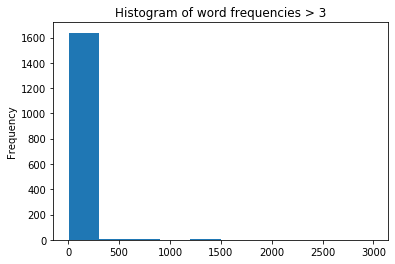

<Figure size 432x288 with 0 Axes>

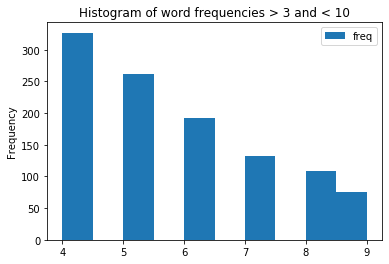

In [3]:
#generate corpus using training citation contexts

df["tokens"] = [word_tokenize(context.replace("#AUTHOR_TAG", "")) for context in df["citation_context"]]


threshold = 3 #frequency threshold for throwing out words

tokenized_corpus = []
[tokenized_corpus.extend(word_tokenize(context.replace("#AUTHOR_TAG", ""))) for context in df["citation_context"]]
fdist = nltk.FreqDist(tokenized_corpus)
fdftotal = pd.DataFrame(fdist.items(), columns = ['word', 'freq'])

print("Total number of unique words in training corpus: {}".format(len(fdftotal)))
fdf = fdftotal.loc[fdftotal.freq > threshold]
print("Number of unique words with frequency > {} in training corpus: {}".format(threshold, len(fdf)))

fdf["freq"].plot(kind="hist")
plt.title("Histogram of word frequencies > {}".format(threshold))
plt.figure()
fdf.loc[fdf.freq < 10].plot(kind="hist")
plt.title("Histogram of word frequencies > {} and < 10".format(threshold))

One interesting question is at what frequency to threshold words. I will explore all but find a threshold at 3 to be good. I print some example words from each frequency below

In [4]:
print(fdftotal.loc[fdftotal.freq == 3].head)
print(fdftotal.loc[fdftotal.freq == 4].head)

<bound method NDFrame.head of                word  freq
32          created     3
62         supports     3
69            Topic     3
85        evolution     3
103     conferences     3
...             ...   ...
5915  retrospective     3
5916   Myin-Germeys     3
5919       Shiffman     3
5934          Ganis     3
5955       Forsythe     3

[617 rows x 2 columns]>
<bound method NDFrame.head of              word  freq
2        generate     4
17       Ontology     4
42        dataset     4
57      generated     4
73      Framework     4
...           ...   ...
5724  oncogenetic     4
5749      largely     4
5863    immediate     4
5923    activated     4
5951      Barrett     4

[327 rows x 2 columns]>


##### Generate embeddings using trained GloVe model

In [5]:
#assemble glove embeddings

glovepath = "../../Utilties/glove"
embeddings_dict = {}
with open(glovepath + "/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [6]:
#Generate embeddings out of tokenized sentences
def embed_context(tokens, fdf):
    vector = []
    for word in tokens:
        if word in fdf["word"].values and word in embeddings_dict:
            vector.append(embeddings_dict[word])
    return np.sum(vector, axis=0)


X = np.array([embed_context(tokens, fdf) for tokens in df["tokens"]])
print(X.shape)

(1000, 50)


##### Train model with embedded features

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

y = df["citation_class_label"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

model = SVC()
model.fit(X_train, y_train)

model.score(X_test, y_test)

0.535

##### Ok, that was pretty bad. What is the ideal frequency filter?

In [8]:
for threshold in range(1, 20):
    fdf = fdftotal.loc[fdftotal.freq > threshold]

    X = np.array([embed_context(tokens, fdf) for tokens in df["tokens"]])
    y = df["citation_class_label"].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

    model = SVC()
    model.fit(X_train, y_train)

    print("Threshold Frequency: {}, Score: {}".format(threshold, model.score(X_test, y_test)))

Threshold Frequency: 1, Score: 0.535
Threshold Frequency: 2, Score: 0.535
Threshold Frequency: 3, Score: 0.535
Threshold Frequency: 4, Score: 0.535
Threshold Frequency: 5, Score: 0.535
Threshold Frequency: 6, Score: 0.535
Threshold Frequency: 7, Score: 0.535
Threshold Frequency: 8, Score: 0.535
Threshold Frequency: 9, Score: 0.535
Threshold Frequency: 10, Score: 0.535
Threshold Frequency: 11, Score: 0.535
Threshold Frequency: 12, Score: 0.535
Threshold Frequency: 13, Score: 0.535
Threshold Frequency: 14, Score: 0.535
Threshold Frequency: 15, Score: 0.535
Threshold Frequency: 16, Score: 0.535
Threshold Frequency: 17, Score: 0.535
Threshold Frequency: 18, Score: 0.535
Threshold Frequency: 19, Score: 0.535


So it looks like this feature is quite bad. The classifier is barely doing better than random, although with 6 classes you could argue this is quite good.

###### What about 1 vs all for Background, the largest class?

In [9]:
for threshold in range(1, 20):
    fdf = fdftotal.loc[fdftotal.freq > threshold]

    X = np.array([embed_context(tokens, fdf) for tokens in df["tokens"]])
    y = df["citation_class_label"].values
    y = np.array([i == 0 for i in y])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

    model = SVC()
    model.fit(X_train, y_train)

    print("Threshold Frequency: {}, Score: {}".format(threshold, model.score(X_test, y_test)))

Threshold Frequency: 1, Score: 0.535
Threshold Frequency: 2, Score: 0.535
Threshold Frequency: 3, Score: 0.535
Threshold Frequency: 4, Score: 0.535
Threshold Frequency: 5, Score: 0.535
Threshold Frequency: 6, Score: 0.535
Threshold Frequency: 7, Score: 0.535
Threshold Frequency: 8, Score: 0.535
Threshold Frequency: 9, Score: 0.535
Threshold Frequency: 10, Score: 0.535
Threshold Frequency: 11, Score: 0.535
Threshold Frequency: 12, Score: 0.535
Threshold Frequency: 13, Score: 0.535
Threshold Frequency: 14, Score: 0.535
Threshold Frequency: 15, Score: 0.535
Threshold Frequency: 16, Score: 0.535
Threshold Frequency: 17, Score: 0.535
Threshold Frequency: 18, Score: 0.54
Threshold Frequency: 19, Score: 0.54


##### Attempt with LibSVM

In [11]:
from libsvm.svmutil import *

threshold = 3

fdf = fdftotal.loc[fdftotal.freq > threshold]

X = np.array([embed_context(tokens, fdf) for tokens in df["tokens"]])
y = df["citation_class_label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

m = svm_train(y_train, X_train, '-c 6')

p_label, p_acc, p_val = svm_predict(y_test, X_test, m)

Accuracy = 58% (116/200) (classification)


### Experiment 2: Corpus = Brown Corpus
With the Brown corpus, the generated feature still fails.

In [12]:
words = nltk.corpus.brown.words()
freqs = nltk.FreqDist(words)

Total number of unique words in training corpus: 56057
Number of unique words with frequency > 3 in training corpus: 17904


Text(0.5, 1.0, 'Histogram of word frequencies > 3 and < 10')

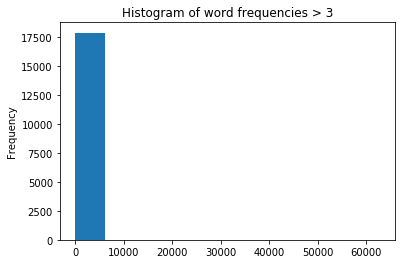

<Figure size 432x288 with 0 Axes>

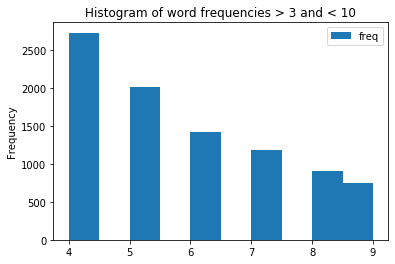

In [13]:
threshold = 3

fdftotal = pd.DataFrame(freqs.items(), columns = ['word', 'freq'])

print("Total number of unique words in training corpus: {}".format(len(fdftotal)))
fdf = fdftotal.loc[fdftotal.freq > threshold]
print("Number of unique words with frequency > {} in training corpus: {}".format(threshold, len(fdf)))

fdf["freq"].plot(kind="hist")
plt.title("Histogram of word frequencies > {}".format(threshold))
plt.figure()
fdf.loc[fdf.freq < 10].plot(kind="hist")
plt.title("Histogram of word frequencies > {} and < 10".format(threshold))

In [16]:
#Multiclass SVM

for threshold in range(1, 3):
    fdf = fdftotal.loc[fdftotal.freq > threshold]

    X = np.array([embed_context(tokens, fdf) for tokens in df["tokens"]])
    y = df["citation_class_label"].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

    model = SVC()
    model.fit(X_train, y_train)

    print("Threshold Frequency: {}, Score: {}".format(threshold, model.score(X_test, y_test)))

Threshold Frequency: 1, Score: 0.535
Threshold Frequency: 2, Score: 0.535


##### Attempt with LibSVM

In [17]:
from libsvm.svmutil import *

threshold = 3

fdf = fdftotal.loc[fdftotal.freq > threshold]

X = np.array([embed_context(tokens, fdf) for tokens in df["tokens"]])
y = df["citation_class_label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

m = svm_train(y_train, X_train, '-c 6')

p_label, p_acc, p_val = svm_predict(y_test, X_test, m)

Accuracy = 58.5% (117/200) (classification)


### ADABoost, ROC

In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [19]:
threshold = 3

fdf = fdftotal.loc[fdftotal.freq > threshold]

X = np.array([embed_context(tokens, fdf) for tokens in df["tokens"]])
y = df["citation_class_label"].values
y = label_binarize(y, classes = [0, 1, 2, 3, 4, 5, 6])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

print(y_test.shape)

(200, 7)


In [20]:
clf = OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, random_state=0))
clf.fit(X_train, y_train).decision_function(X_test)
y_pred = clf.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\multiclass.py:75: UserWarning: Label not 6 is present in all training examples.
  str(classes[c]))


In [21]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


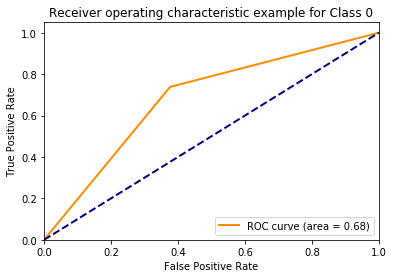

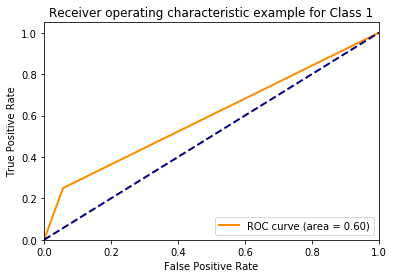

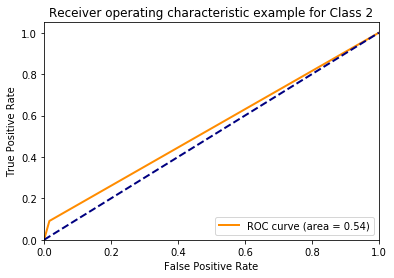

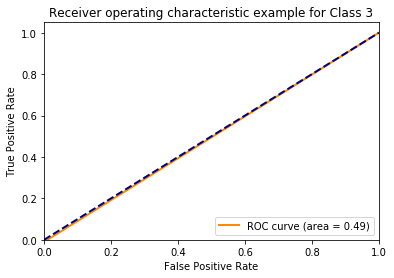

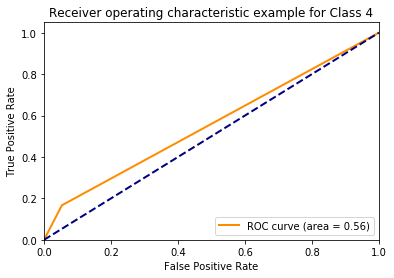

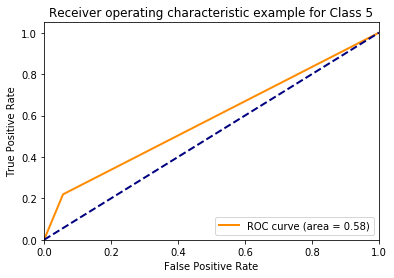

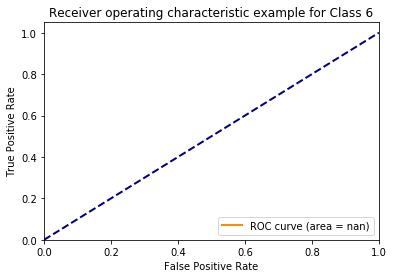

In [22]:
for i in range(7):
    plt.figure()
    lw = 2
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example for Class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()